# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.utils import poly_to_img

/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data

### Initialise datasets

In [2]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Ploting the data

#### Training data

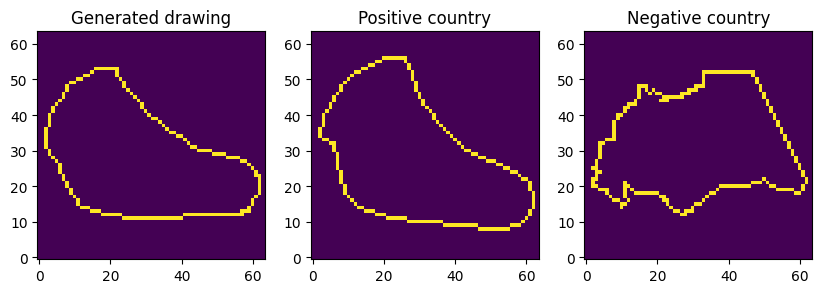

In [28]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

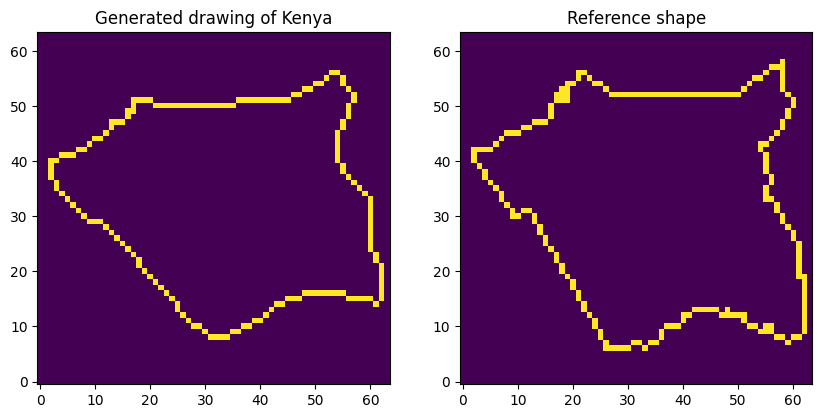

In [27]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

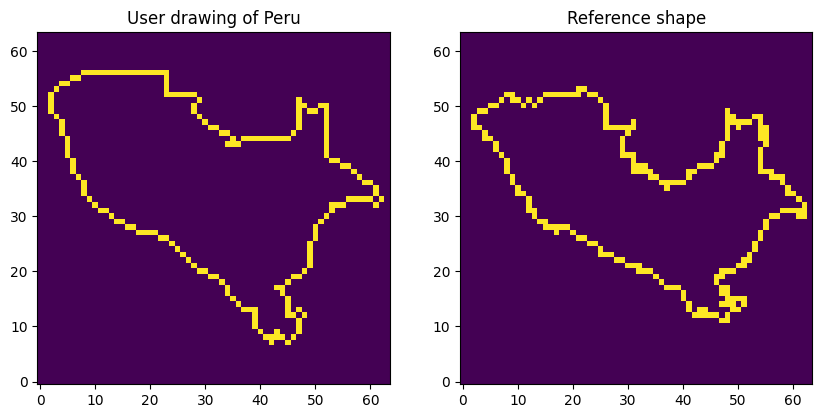

In [26]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

### Define Model
The model should have a load reference method and a rank countries method

In [3]:
class Model(nn.Module):
    def __init__(self, dims=[1, 16, 32, 64, 80, 16*80, 96], shape=(64, 64)):
        super().__init__()
        self.shape = shape
        self._ref_countries = None
        self.conv_1 = self.conv_block(dims[0], dims[1])
        self.conv_2 = self.conv_block(dims[1], dims[2])
        self.conv_3 = self.conv_block(dims[2], dims[3])
        self.conv_4 = self.conv_block(dims[3], dims[4])
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(dims[5], dims[6])

    
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.Conv2d(out_dim, out_dim, 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.Conv2d(out_dim, out_dim, 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.MaxPool2d(2))


    def __call__(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        
        return x

    
    def load_reference(self, ref_data):
        self._ref_countries = {}
        for idx in range(len(ref_data)):
            img = poly_to_img(ref_data[idx], ref_data.shape)
            embedding = self(torch.tensor(img[None, None, :, :], dtype=torch.float32).to(device))
            self._ref_countries[ref_data.country_name[idx]] = embedding

    
    @torch.no_grad
    def rank_countries(self, drawings):
        embedding = self(drawings)
        countries = []
        distances = []

        if not self._ref_countries:
            raise Exception("First the reference dataset needs to be loaded!")            

        for country, ref_emb in self._ref_countries.items():
            countries.append(country)
            distance = torch.linalg.norm(embedding - ref_emb, axis=-1)
            distances.append(distance.cpu())

        return countries, np.array(distances)

In [4]:
def triplet_mining(anc_emb, pos_emb, neg_emb, pos_idx, neg_idx):
    #All combinations
    anc_emb = anc_emb.tile((anc_emb.shape[0], 1))
    pos_emb = pos_emb.tile((pos_emb.shape[0], 1))
    neg_emb = neg_emb.repeat(neg_emb.shape[0], 1)
    pos_idx = pos_idx.tile((pos_idx.shape[0]))
    neg_idx = neg_idx.repeat((neg_idx.shape[0]))
    
    #Mask valid triplets
    valid = pos_idx!=neg_idx
    
    return anc_emb[valid], pos_emb[valid], neg_emb[valid]

In [5]:
def eval_fn(model, batch):
    drawings = batch['drawing'][:, None, :, :].type(torch.float32).to(device)
    countries, distances = model.rank_countries(drawings)
    all_rank = np.argsort(distances, axis=0)
    index = [countries.index(country) for country in batch['country_name']]
    rank = np.argmax(all_rank==index, axis=0)

    return rank

### Train model

In [6]:
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

In [7]:
device = torch.device("mps")

In [44]:
mlflow.set_experiment("triplet_model")

params = {"embedding_size": 160,
          "learning_rate": 0.008, 
          "margin": 0.8,
          "nr_epochs": 64}

model = Model(dims=[1, 16, 32, 64, 80, 16*80, params["embedding_size"]]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

In [ ]:
mlflow.start_run()
mlflow.log_params(params)

#Start training
for epoch in range(params['nr_epochs']):
    losses = []        
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()
        anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
        pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
        neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))

        #Mine triplets
        anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                   batch["pos_idx"], batch["neg_idx"])

        loss = triplet_loss(anc_emb, pos_emb, neg_emb)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    mlflow.log_metric("loss", np.mean(losses), epoch)
    
    print('Epoch: {}\t loss: {:.3f}'.format(epoch, np.mean(losses)))

    if (epoch+1)%4==0:
        ranking = np.array([])
        model.eval()
        model.load_reference(ref_data)
        for batch in val_dl:
            rank = eval_fn(model, batch)
            ranking = np.append(ranking, rank)

        mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
        mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
        mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)

        print('Epoch: {}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
              .format(epoch, np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

model_info = mlflow.pytorch.log_model(model, "model")
mlflow.end_run()

Epoch: 0	 loss: 0.288
Epoch: 1	 loss: 0.135
Epoch: 2	 loss: 0.181
Epoch: 3	 loss: 0.091
Epoch: 3	 Average rank: 8.88	 top 10 acc: 79.7%	 top 1 acc: 48.1%	
Epoch: 4	 loss: 0.101
Epoch: 5	 loss: 0.057
Epoch: 6	 loss: 0.072
Epoch: 7	 loss: 0.073
Epoch: 7	 Average rank: 6.95	 top 10 acc: 85.7%	 top 1 acc: 45.6%	
Epoch: 8	 loss: 0.052
Epoch: 9	 loss: 0.073
Epoch: 10	 loss: 0.049
Epoch: 11	 loss: 0.055
Epoch: 11	 Average rank: 5.46	 top 10 acc: 86.5%	 top 1 acc: 49.8%	
Epoch: 12	 loss: 0.048
Epoch: 13	 loss: 0.045
Epoch: 14	 loss: 0.050
Epoch: 15	 loss: 0.048
Epoch: 15	 Average rank: 6.01	 top 10 acc: 89.0%	 top 1 acc: 55.3%	
Epoch: 16	 loss: 0.059
Epoch: 17	 loss: 0.047
Epoch: 18	 loss: 0.042
Epoch: 19	 loss: 0.077
Epoch: 19	 Average rank: 6.00	 top 10 acc: 86.1%	 top 1 acc: 52.7%	
Epoch: 20	 loss: 0.028
Epoch: 21	 loss: 0.070
Epoch: 22	 loss: 0.080
Epoch: 23	 loss: 0.037


### Evaluate model

In [20]:
test_dl = DataLoader(test_data, batch_size=32)

In [ ]:
ranking = np.array([])
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=model_info.run_id):
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [ ]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

In [ ]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

## Register model
Compare models and push to producton

In [138]:
best_run = mlflow.search_runs(order_by=["metrics.test_avg_rank ASC"]).iloc[0]
mlflow.register_model(f"runs:/{best_run.run_id}/model", "Model")

Registered model 'Model' already exists. Creating a new version of this model...
Created version '2' of model 'Model'.


<ModelVersion: aliases=[], creation_timestamp=1714761765025, current_stage='None', description=None, last_updated_timestamp=1714761765025, name='Model', run_id='e6e9ca159b304b7ab1224f65240f6d5b', run_link=None, source='file:///Users/jortdejong/GitHub/country-guess/mlruns/0/e6e9ca159b304b7ab1224f65240f6d5b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>